In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np


In [2]:
data = pd.read_csv("diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [28]:
data = data.drop(columns=['Outcome'])


KeyError: "['Outcome'] not found in axis"

In [ ]:
# 데이터와 타겟 분리
X = data.drop(['BMI'], axis=1).values
y = data['BMI'].values

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [30]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


/var/folders/tx/rw4964jj7qjgx3sd1vrtdgz00000gn/T/ipykernel_33546/2830580779.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/tx/rw4964jj7qjgx3sd1vrtdgz00000gn/T/ipykernel_33546/2830580779.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
/var/folders/tx/rw4964jj7qjgx3sd1vrtdgz00000gn/T/ipykernel_33546/2830580779.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch

In [31]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 7]),
 torch.Size([154, 7]),
 torch.Size([614, 1, 1]),
 torch.Size([154, 1, 1]))

In [33]:
class DiabetesRegressor(nn.Module):
    def __init__(self):
        super(DiabetesRegressor, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesRegressor()

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
train_losses = []
train_mses = []
test_mses = []

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_mse = 0.0
    total_samples = 0
    
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # MSE 계산 (batch마다)
        mse = ((outputs - labels) ** 2).mean()
        train_mse += mse.item() * inputs.size(0)  # 전체 샘플수로 평균 내기 위해
        
        total_samples += inputs.size(0)
    

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_mse = train_mse / total_samples
    train_mses.append(train_epoch_mse)


    model.eval()
    test_mse = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            mse = ((outputs - labels) ** 2).mean()
            test_mse += mse.item() * inputs.size(0)

            total_samples += inputs.size(0)

    test_epoch_mse = test_mse / total_samples
    test_mses.append(test_epoch_mse)
            

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_epoch_loss:.4f}, Train MSE: {train_epoch_mse:.4f}, Test MSE: {test_epoch_mse:.4f}")

print("Training complete.")


/Users/park-yeonseo/tensorflow_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/park-yeonseo/tensorflow_env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 1090.3102, Train MSE: 1084.6908, Test MSE: 996.8595
Epoch 2/100, Loss: 1033.8105, Train MSE: 1040.9015, Test MSE: 939.8034
Epoch 3/100, Loss: 949.5269, Train MSE: 959.6403, Test MSE: 838.4690
Epoch 4/100, Loss: 820.0918, Train MSE: 823.8151, Test MSE: 681.7105
Epoch 5/100, Loss: 624.6726, Train MSE: 633.5707, Test MSE: 480.0698
Epoch 6/100, Loss: 419.4953, Train MSE: 415.9998, Test MSE: 285.8957
Epoch 7/100, Loss: 239.3731, Train MSE: 240.9764, Test MSE: 159.7321
Epoch 8/100, Loss: 149.7863, Train MSE: 152.0082, Test MSE: 114.4682
Epoch 9/100, Loss: 126.0255, Train MSE: 122.4819, Test MSE: 102.6160
Epoch 10/100, Loss: 114.7922, Train MSE: 114.6127, Test MSE: 98.1175
Epoch 11/100, Loss: 106.0900, Train MSE: 108.5766, Test MSE: 95.1817
Epoch 12/100, Loss: 106.5467, Train MSE: 107.0237, Test MSE: 93.4026
Epoch 13/100, Loss: 99.6281, Train MSE: 102.3554, Test MSE: 91.0099
Epoch 14/100, Loss: 102.6876, Train MSE: 102.3013, Test MSE: 89.2033
Epoch 15/100, Loss: 98.4676, Tr

In [36]:
# 모델 평가

In [39]:
# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        outputs = outputs.view(-1) 
        labels = labels.view(-1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

all_labels_rounded = np.round(all_labels)
all_predictions_rounded = np.round(all_predictions)

mse = mean_squared_error(all_labels, all_predictions)
mae = mean_absolute_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

conf_matrix = confusion_matrix(all_labels_rounded, all_predictions_rounded)

print(f'Confusion Matrix:\n{conf_matrix}')

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 4 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 5 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 6 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 4 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 4 3 0 0 

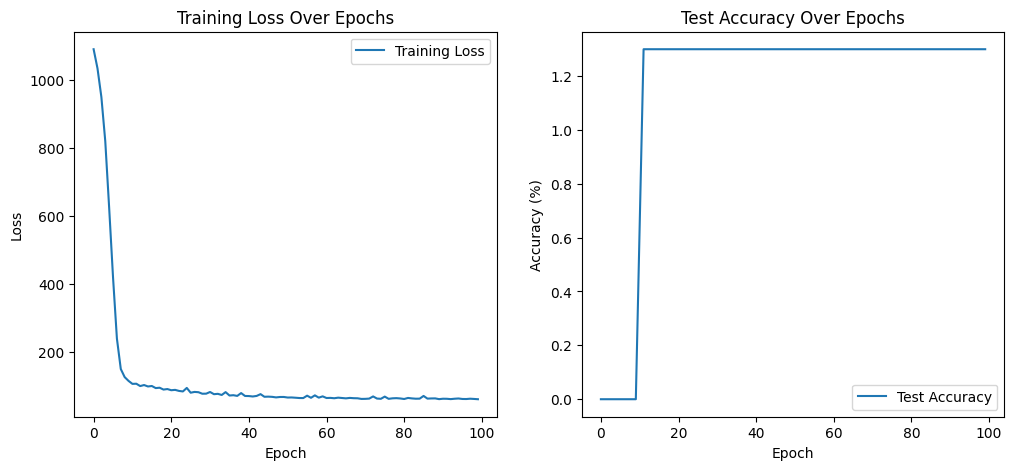

In [40]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

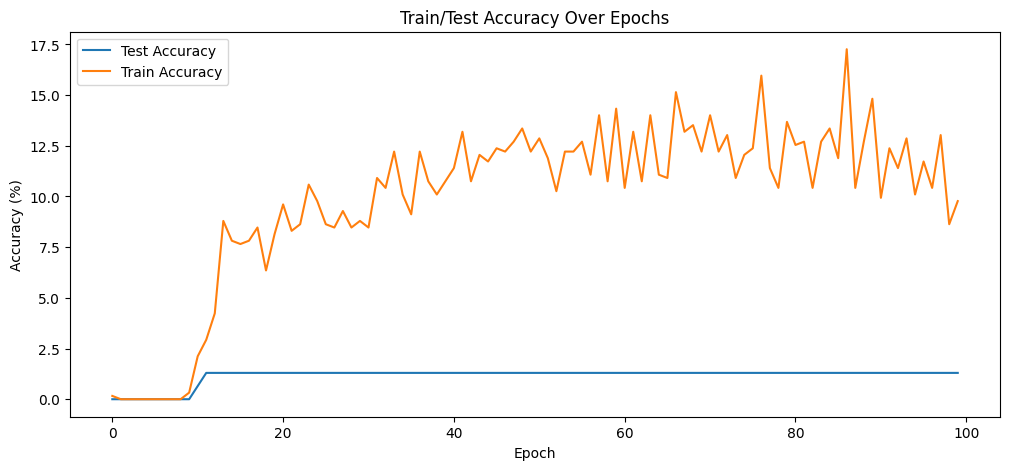

In [41]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))


# Plot accuracy
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy Over Epochs')
plt.legend()

plt.show()